# Import

In [211]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import umap
from umap.umap_ import nearest_neighbors

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datensatz

In [64]:
filename = "data/tanimoto_all_gnps_240116_dataframe.pickle"
data = pd.read_pickle(filename)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20187 entries, IYDKWWDUBYWQGF to VFRROHXSMXFLSN
Columns: 20187 entries, IYDKWWDUBYWQGF to VFRROHXSMXFLSN
dtypes: float64(20187)
memory usage: 3.0+ GB


In [19]:
data.head()

,IYDKWWDUBYWQGF,WCNJVJCYRBJSLC,NAIKIJSSBJHCBL,GWGKNTICBPKKKW,FFCLYSVFZQXUHI,DEUCVOIWOGPZGS,ZRWKFXOGNFQPMY,VCAGNEUDNVLWPT,LNZVLFKJDOYTAA,QURRTAYEASAREY,...,IRLPACMLTUPBCL,CILLXFBAACIQNS,SXYMMDGPXYVCER,WRFPVMFCRNYQNR,IKHGUXGNUITLKF,RFSUNEUAIZKAJO,RQEUFEKYXDPUSK,QWVGKYWNOKOFNN,DBZAKQWXICEWNW,VFRROHXSMXFLSN
IYDKWWDUBYWQGF,1.000000,0.525466,0.295739,0.499241,0.464567,0.425751,0.426005,0.458942,0.446890,0.423913,...,0.383570,0.360222,0.343192,0.184685,0.005900,0.146067,0.079961,0.060403,0.084777,0.118317
WCNJVJCYRBJSLC,0.525466,1.000000,0.274548,0.537179,0.381674,0.423787,0.430822,0.357287,0.609177,0.369201,...,0.495506,0.463293,0.449582,0.161873,0.004170,0.144728,0.061941,0.048730,0.098093,0.126742
NAIKIJSSBJHCBL,0.295739,0.274548,1.000000,0.258853,0.258985,0.246561,0.250264,0.252525,0.252773,0.251282,...,0.230392,0.216350,0.211278,0.104914,0.011236,0.127005,0.054545,0.022989,0.086022,0.120056
GWGKNTICBPKKKW,0.499241,0.537179,0.258853,1.000000,0.528855,0.622470,0.631846,0.481731,0.429922,0.488688,...,0.353598,0.358812,0.355911,0.210983,0.006257,0.148551,0.090256,0.063959,0.080153,0.120515
FFCLYSVFZQXUHI,0.464567,0.381674,0.258985,0.528855,1.000000,0.511034,0.518002,0.832840,0.305524,0.472588,...,0.296552,0.268176,0.265647,0.128842,0.009132,0.139151,0.046768,0.043357,0.077922,0.140722


In [65]:
data_full = pd.read_csv('data/compound_classes.txt', sep='\t')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19824 entries, 0 to 19823
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   inchi_key               19824 non-null  object
 1   smiles                  19824 non-null  object
 2   cf_kingdom              18591 non-null  object
 3   cf_superclass           18591 non-null  object
 4   cf_class                18503 non-null  object
 5   cf_subclass             15662 non-null  object
 6   cf_direct_parent        18591 non-null  object
 7   npc_class_results       16108 non-null  object
 8   npc_superclass_results  16617 non-null  object
 9   npc_pathway_results     18582 non-null  object
 10  npc_isglycoside         19824 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.7+ MB


In diesem Skriptabschnitt wird ein spezifischer Prozess zur Datenbereinigung und -abgleichung für eine Sammlung chemischer Verbindungen durchgeführt, wobei der Schwerpunkt auf der Handhabung und Analyse von InChI-Keys liegt. Es werden zwei Datensätze angeschaut: Einmal eine Ähnlichkeitsmatrix und einmal ein Datensatz mit Eigenschaften der Molekular Daten. Zunächst wird der identifizierende Teil des InChI-Keys aus der Datensammlung extrahiert und für jeden Eintrag gespeichert. Anschließend werden doppelte Einträge basierend auf diesem extrahierten Teil entfernt, um die Eindeutigkeit innerhalb der Daten zu gewährleisten. Nach dieser Bereinigung erfolgt ein Abgleich der verbleibenden Einträge mit dem Molekular Datensatz, um Übereinstimmungen zu identifizieren. Die Datensätze werden dann entsprechend dieser Übereinstimmungen neu organisiert und angepasst, wobei am Ende überflüssige Daten entfernt werden, um eine präzise und fokussierte Datensammlung für weitere Analysen bereitzustellen.


In [66]:
# Extrahiere den InChI-Teil
data_full['inchi_part'] = data_full['inchi_key'].apply(lambda x: x.split('-')[0])

# Entferne InChI Part Duplikate
data_full = data_full.drop_duplicates(subset='inchi_part', keep='first')

# Finde die übereinstimmenden InChI-Teile
matching_inchi_parts = set(data_full['inchi_part']).intersection(set(data.columns))

# Behalte in data_full nur Zeilen mit übereinstimmenden InChI-Teilen
data_full = data_full[data_full['inchi_part'].isin(matching_inchi_parts)]

# Sortiere data_full entsprechend der Reihenfolge der übereinstimmenden InChI-Teile
matching_inchi_parts_list = list(matching_inchi_parts)
data_full = data_full.set_index('inchi_part').loc[matching_inchi_parts_list].reset_index()

# Anpassen von `data` um nur übereinstimmende Spalten und Zeilen zu behalten
data = data.loc[matching_inchi_parts_list, matching_inchi_parts_list]

# Entferne die temporäre Spalte `inchi_part` aus data_full
data_full.drop('inchi_part', axis=1, inplace=True)


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14670 entries, QVGFPTYGKPLXPK to KSIHMACFIAFKIG
Columns: 14670 entries, QVGFPTYGKPLXPK to KSIHMACFIAFKIG
dtypes: float64(14670)
memory usage: 1.6+ GB


In [68]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14670 entries, 0 to 14669
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   inchi_key               14670 non-null  object
 1   smiles                  14670 non-null  object
 2   cf_kingdom              13687 non-null  object
 3   cf_superclass           13687 non-null  object
 4   cf_class                13623 non-null  object
 5   cf_subclass             11600 non-null  object
 6   cf_direct_parent        13687 non-null  object
 7   npc_class_results       11978 non-null  object
 8   npc_superclass_results  12367 non-null  object
 9   npc_pathway_results     13778 non-null  object
 10  npc_isglycoside         14670 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.2+ MB


# Visualisierung

Die Kategorie "superclass" wird ausgewählt, da sie nur wenige Einträge aufweist, was zu einer verbesserten Visualisierung führt.

In [24]:
data_full['cf_superclass'].nunique()

19

In diesen Schritten werden SMILES in Mol-Objekte umgewandelt und ungültige Einträge herausgefiltert. Anschließend werden Fingerabdrücke für die gültigen Moleküle berechnet, PCA angewendet und schließlich t-SNE durchgeführt, um eine zweidimensionale Darstellung der Daten zu erhalten.

In [174]:
# Umwandlung von SMILES in Mol-Objekte und Filterung ungültiger Einträge
mols = [Chem.MolFromSmiles(smiles) for smiles in data_full['smiles']]
valid_indices = [i for i, mol in enumerate(mols) if mol is not None]
valid_mols = [mols[i] for i in valid_indices]

# Filterung von data_full entsprechend den gültigen Einträgen
data_full = data_full.iloc[valid_indices]
data = data.iloc[valid_indices]

# Berechnung der Fingerabdrücke für gültige Mol-Objekte
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in valid_mols]

# Umwandlung der Fingerabdrücke in ein Format, das von t-SNE verwendet werden kann
fp_matrix = np.array([list(fp) for fp in fps])

# Durchführung von PCA
pca_model = PCA(n_components=30, random_state=0)

# Durchführung von t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(pca_model.fit_transform(fp_matrix))

# Erstellen eines DataFrames für die t-SNE Ergebnisse
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_2d_one', 'tsne_2d_two'])
tsne_df['cf_superclass'] = data_full['cf_superclass'].values

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_38919/4070639523.py:2: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.scatterplot(


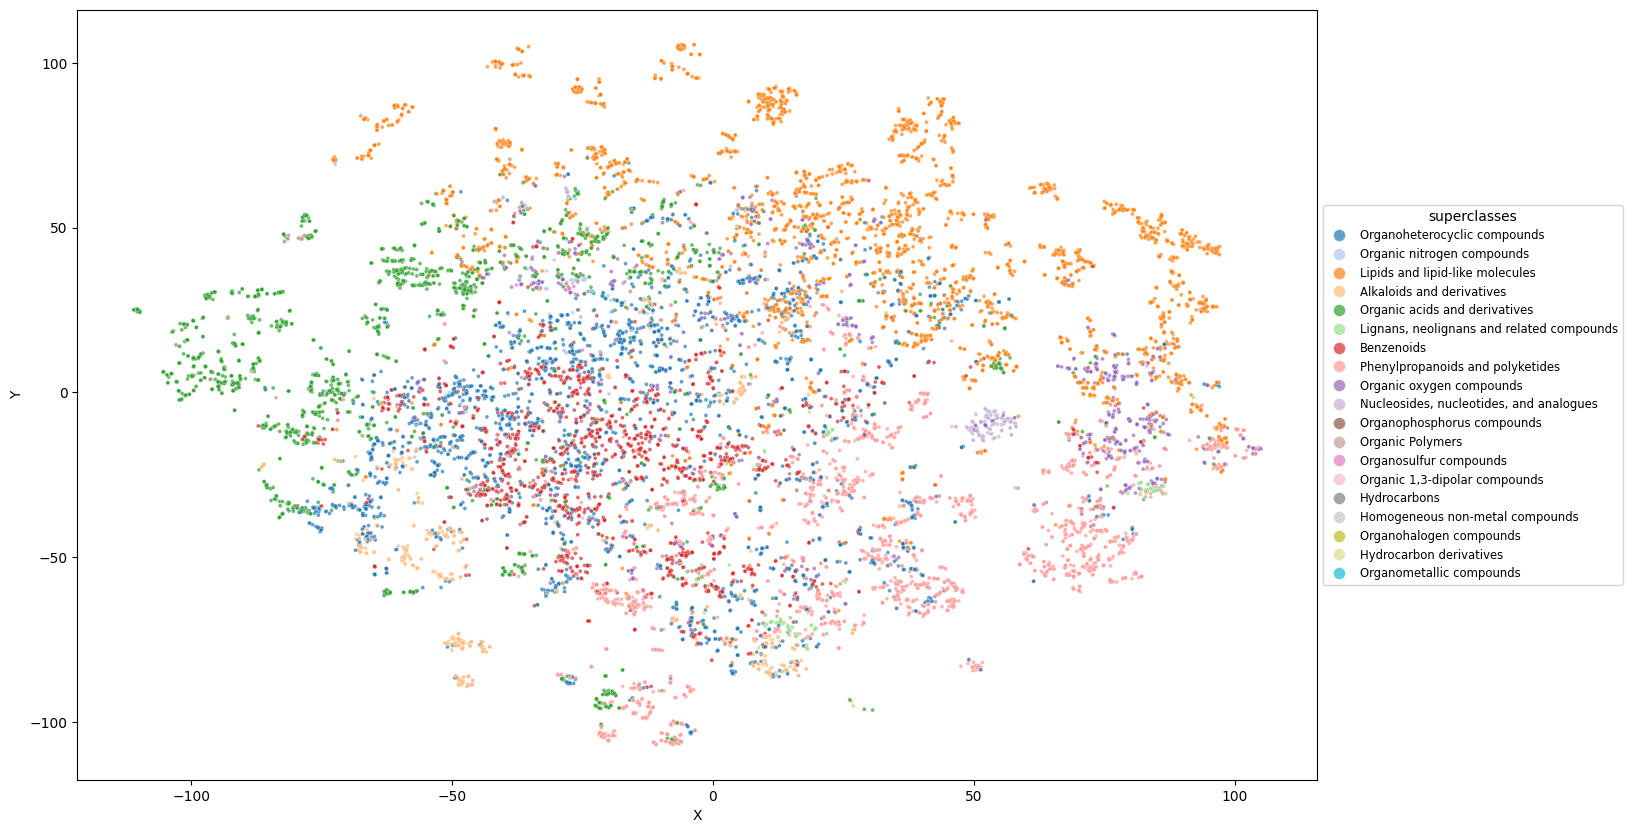

In [201]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="cf_superclass",
    palette=sns.color_palette("tab20", len(tsne_df['cf_superclass'].unique())),
    data=tsne_df,
    alpha=0.7,
    s = 8
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='superclasses', fontsize='small', markerscale=3)
plt.xlabel("X") 
plt.ylabel("Y") 

plt.show()

# Nächste-Nachbarn-Methode

In [83]:
distances = data.to_numpy()

In [145]:
# Hier kann der Schwellenwert n_neighbours festgelegt werden
n_neighbours = 20

# Sortieren der Werte und Auswahl der ersten n_neighbours Werte
sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

# Berechnung der Summe der Werte und der Anzahl der Instanzen in jedem Array
value_sums = [sum(distance_array) for distance_array in sorted_distances]
instance_counts = [len(distance_array) for distance_array in sorted_distances]

# Berechnung des Durchschnitts für jedes Array
averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

# Normalisierung und Transformation
rarity_score = averages
min_score = min(rarity_score)
max_score = max(rarity_score)
rarity_score = (rarity_score - min_score) / (max_score - min_score)

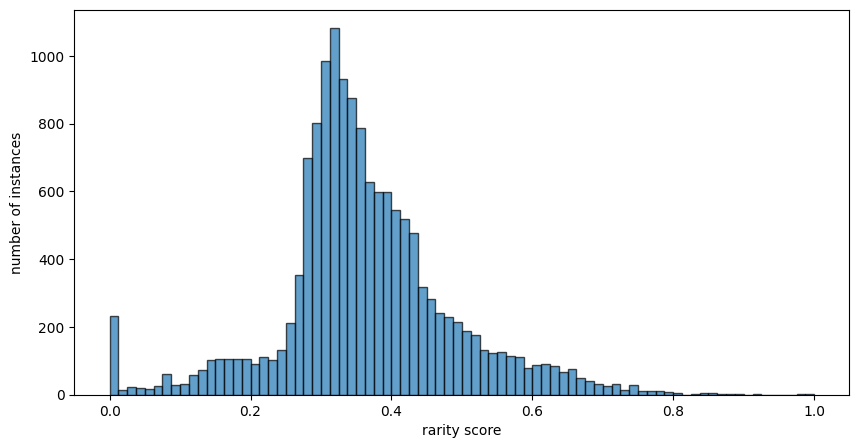

In [202]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('rarity score')
plt.ylabel('number of instances')
plt.show()

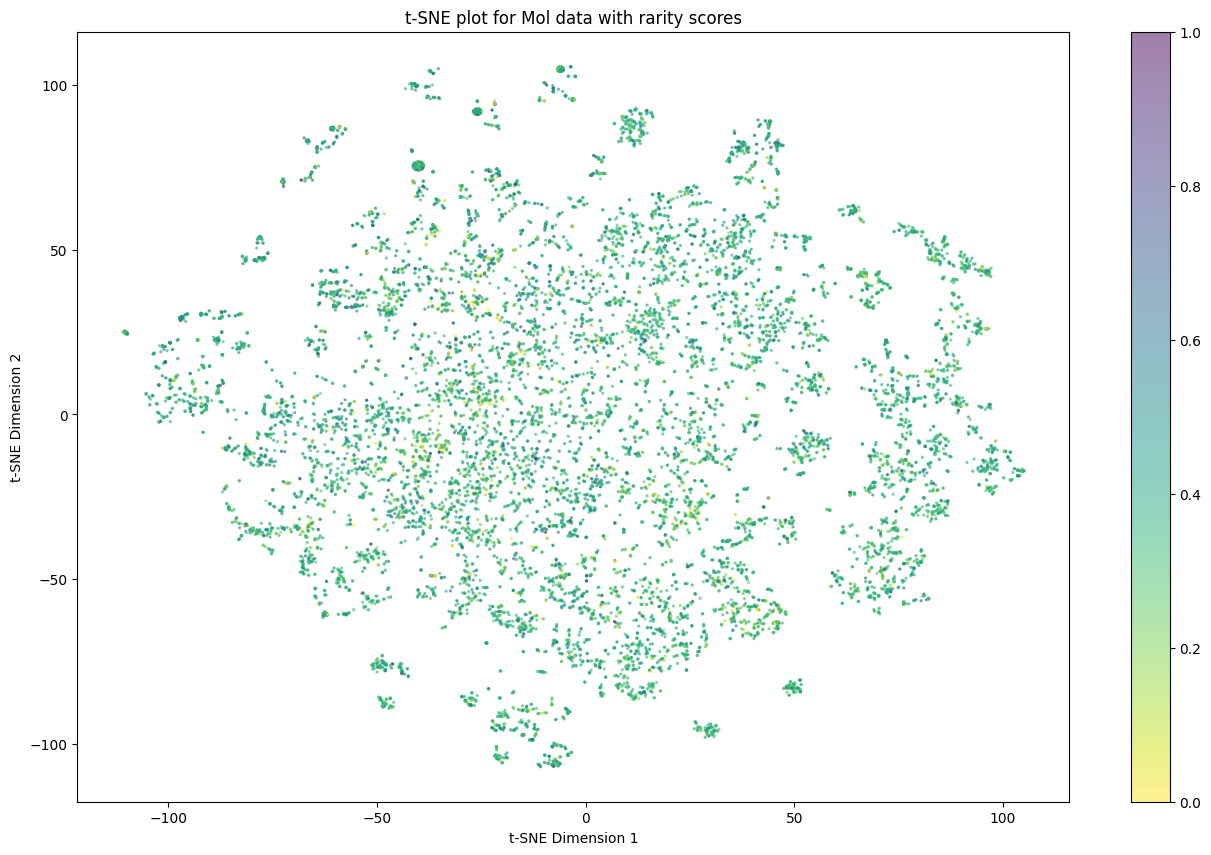

In [203]:
# Erstelle den Plot
plt.figure(figsize=(16,10))
sc = plt.scatter(tsne_df['tsne_2d_one'], tsne_df['tsne_2d_two'], s=2, c=rarity_score, cmap='viridis_r', alpha=0.5)
plt.colorbar(sc)
plt.title('t-SNE plot for Mol data with rarity scores')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Zeige Werte über 0.7 im Plot an

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_38919/2157809624.py:3: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.scatterplot(


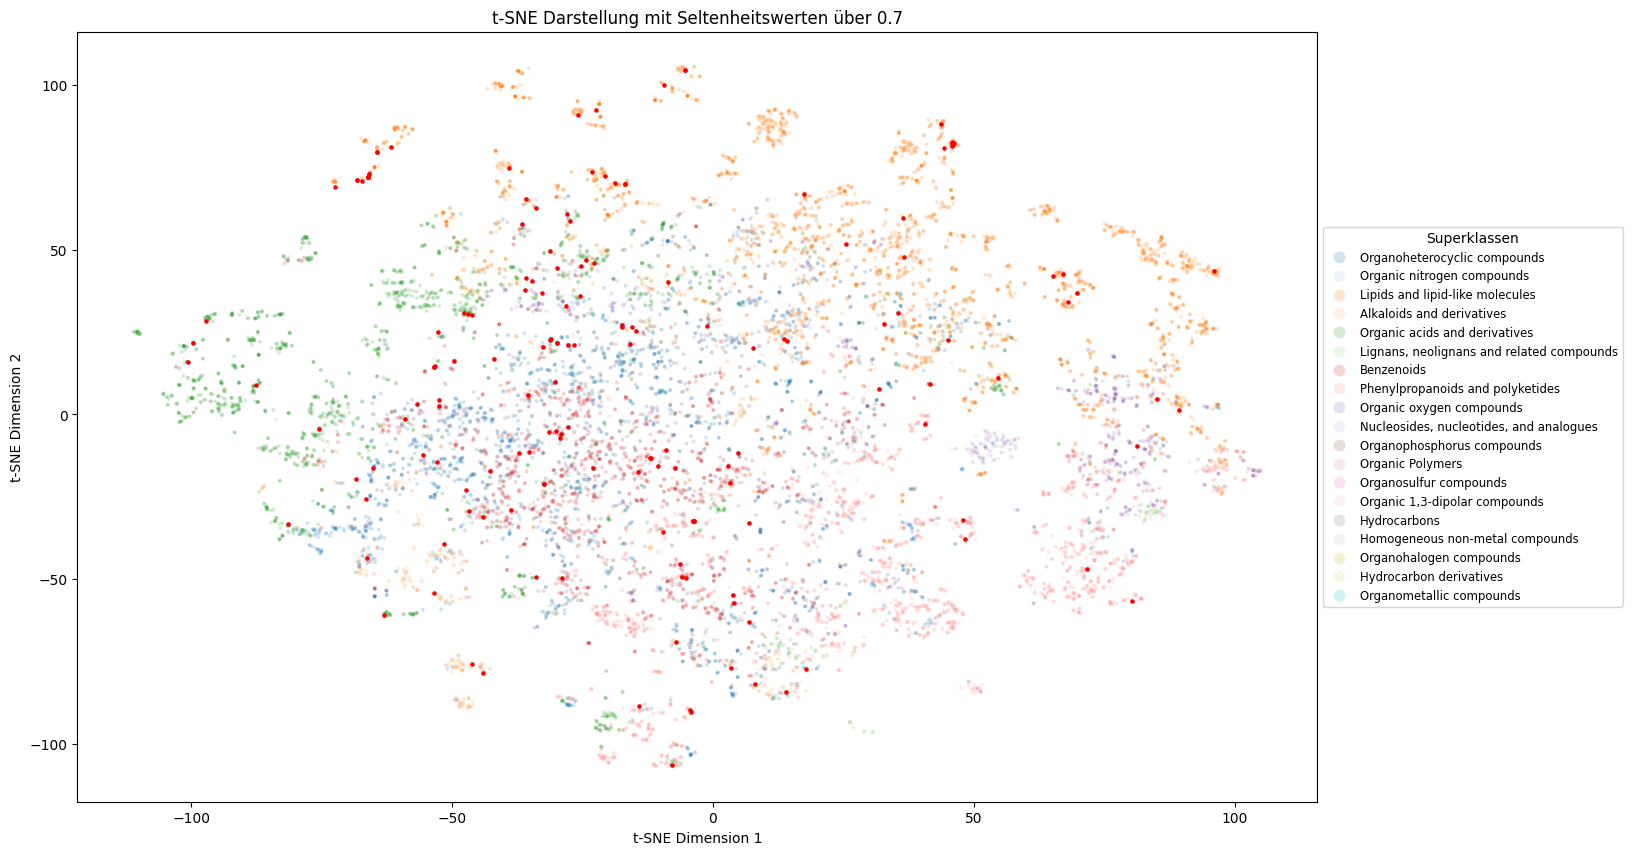

In [210]:
# Erstellen des ersten Scatterplots mit Superklassen und Rarity Scores
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="cf_superclass",
    palette=sns.color_palette("tab20", len(tsne_df['cf_superclass'].unique())),
    data=tsne_df,
    alpha=0.2,
    s=8
)
plt.xlabel("t-SNE Dimension 1") 
plt.ylabel("t-SNE Dimension 2") 
plt.title('t-SNE Darstellung mit Seltenheitswerten über 0.7')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Superklassen', fontsize='small', markerscale=3)

# Annahme: rarity_scores ist ein separates Array mit Rarity-Scores
rarity_scores_filtered = rarity_score > 0.7

# Punkte mit Rarity-Scores über 0.75 in Rot darstellen
plt.scatter(tsne_df.loc[rarity_scores_filtered, 'tsne_2d_one'], tsne_df.loc[rarity_scores_filtered, 'tsne_2d_two'], c='red', s=5)

plt.show()


# Flow Methode

In [88]:
# Berechnung von Flüssen basierend auf der Distanz mit einem Abklingparameter
def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

# Sortieren der Werte, um ihre sortierten Indizes zu erhalten
sorted_ids = np.argsort(distances)

# Hier kann der Schwellenwert n_next_hubs festgelegt werden
n_next_hubs = 200

# Iterative Flusssuche
inward_flow_results = np.zeros(len(distances))
for id in tqdm(range(len(distances))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(distances[id, idx]).sum()

# Normalisierung und Transformation
rarity_score_flow = 1-inward_flow_results
min_score = min(rarity_score_flow)
max_score = max(rarity_score_flow)
rarity_score_flow = (rarity_score_flow - min_score) / (max_score - min_score)

100%|██████████| 14669/14669 [00:00<00:00, 81673.67it/s]


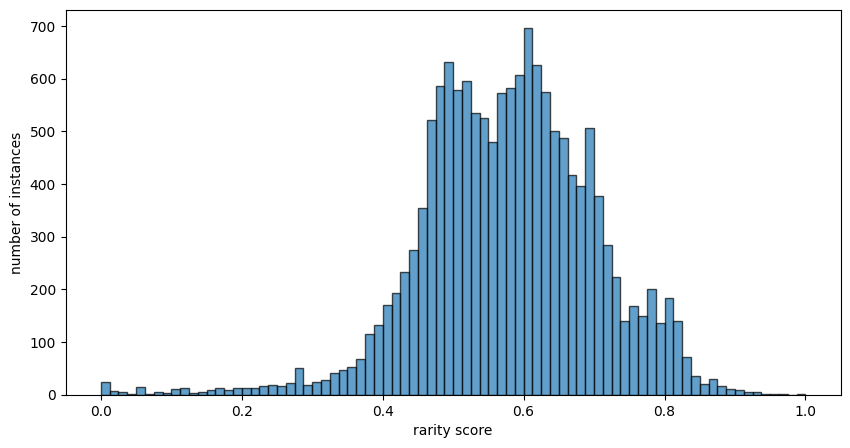

In [205]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_flow, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('rarity score')
plt.ylabel('number of instances')
plt.show()

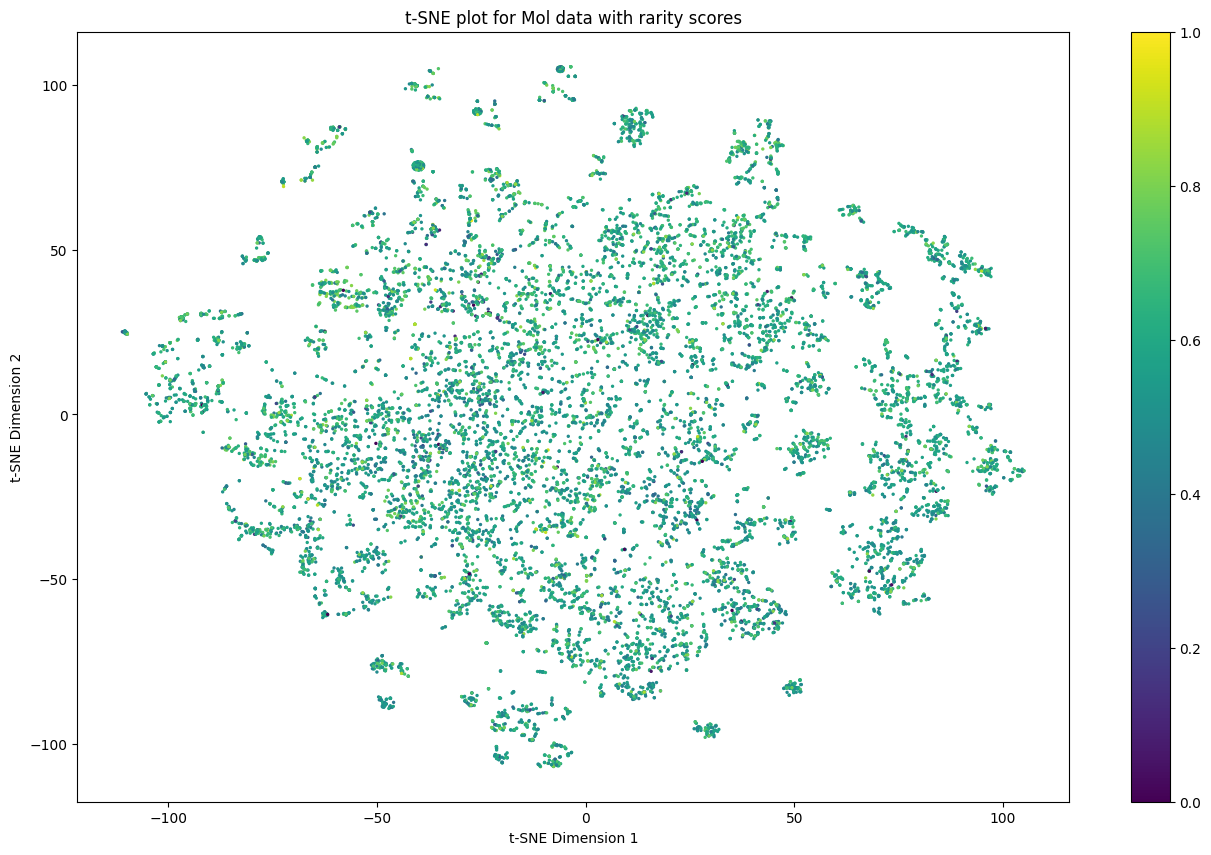

In [206]:
# Erstelle den Plot
plt.figure(figsize=(16,10))
sc = plt.scatter(tsne_df['tsne_2d_one'], tsne_df['tsne_2d_two'], s=2, c=rarity_score_flow, cmap='viridis')
plt.colorbar(sc)
plt.title('t-SNE plot for Mol data with rarity scores')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_38919/96037997.py:3: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.scatterplot(


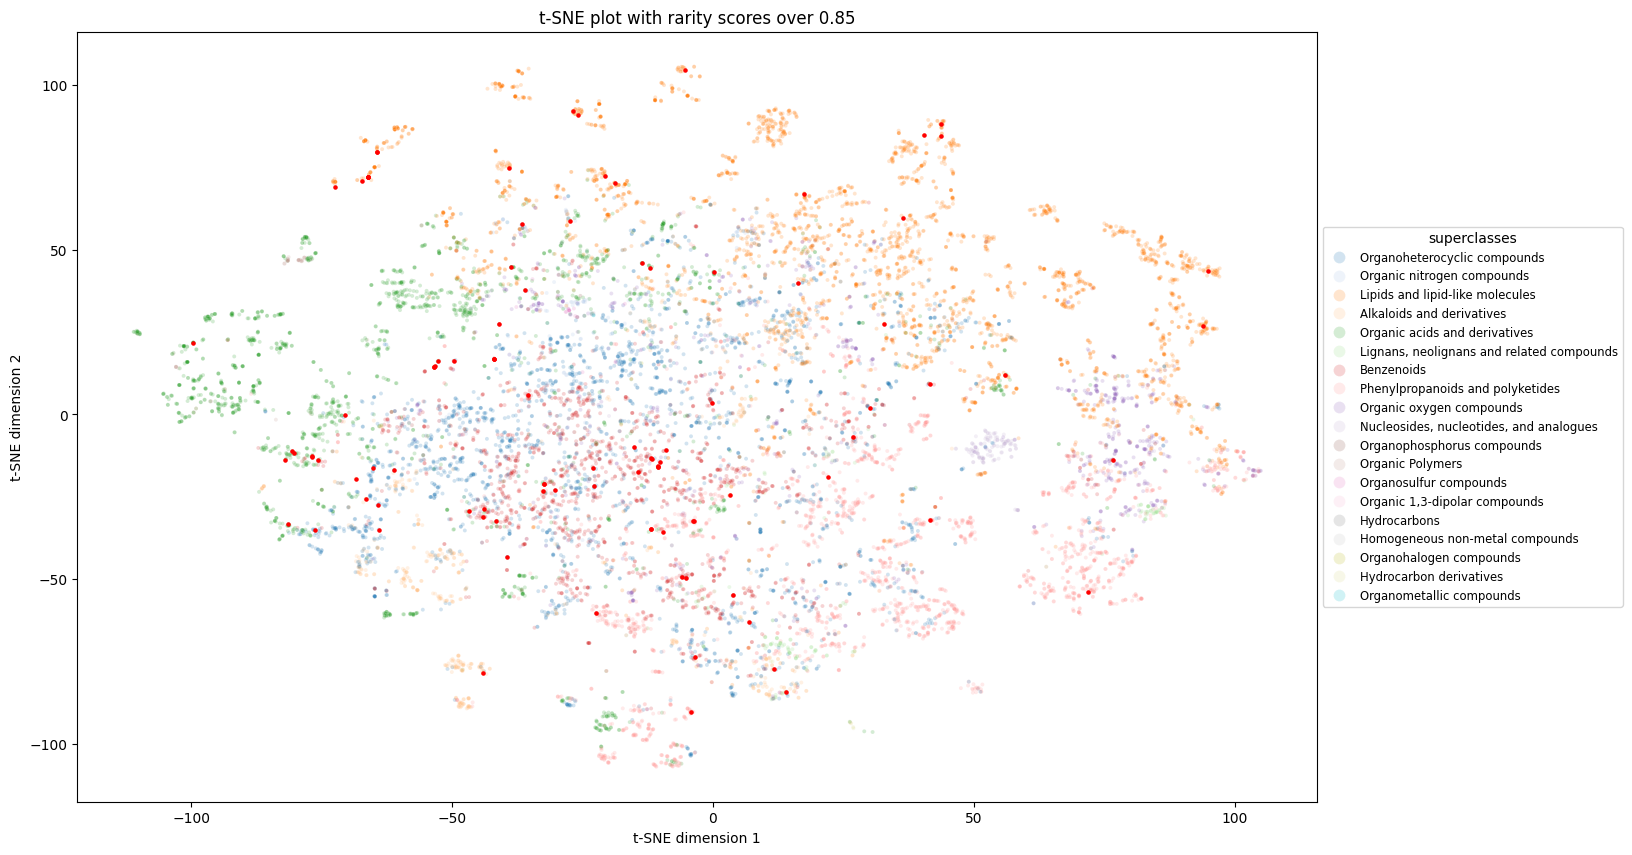

In [207]:
# Erstellen des ersten Scatterplots mit Superklassen und Rarity Scores
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="cf_superclass",
    palette=sns.color_palette("tab20", len(tsne_df['cf_superclass'].unique())),
    data=tsne_df,
    alpha=0.2,
    s=8
)
plt.xlabel("t-SNE dimension 1") 
plt.ylabel("t-SNE dimension 2") 
plt.title('t-SNE plot with rarity scores over 0.85')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='superclasses', fontsize='small', markerscale=3)

# Annahme: rarity_scores ist ein separates Array mit Rarity-Scores
rarity_scores_filtered = rarity_score_flow > 0.85

# Punkte mit Rarity-Scores über 0.75 in Rot darstellen
plt.scatter(tsne_df.loc[rarity_scores_filtered, 'tsne_2d_one'], tsne_df.loc[rarity_scores_filtered, 'tsne_2d_two'], c='red', s=5)

plt.show()


# Ausreißer Methoden

## LOF

In [212]:
from pyod.models.lof import LOF

# LOF-Modell mit 200 Nachbarn instanziieren
lof = LOF(n_neighbors=200, novelty=True, metric='cosine')

# LOF an der Ähnlichkeitsmatrix anpassen
lof.fit(distances)

# Anomalie-Scores berechnen
rarity_score_lof = lof.decision_function(distances)

# Normalisierung der Scores
min_score = min(rarity_score_lof)
max_score = max(rarity_score_lof)
rarity_score_lof = (rarity_score_lof - min_score) / (max_score - min_score)

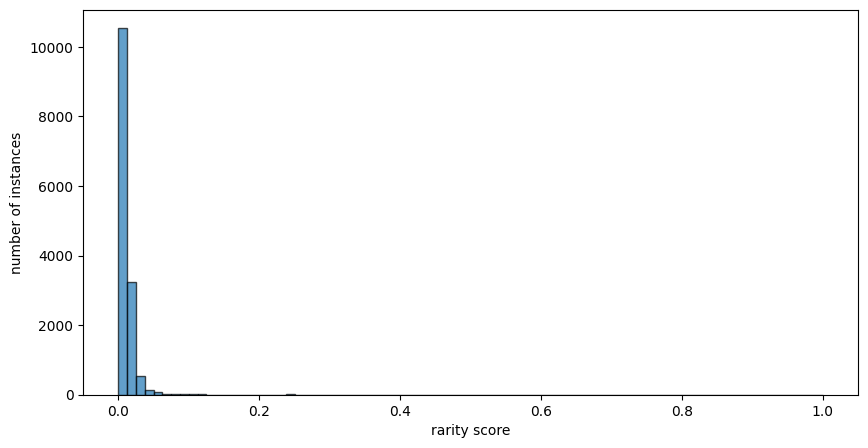

In [213]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_lof, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('rarity score')
plt.ylabel('number of instances')
plt.show()

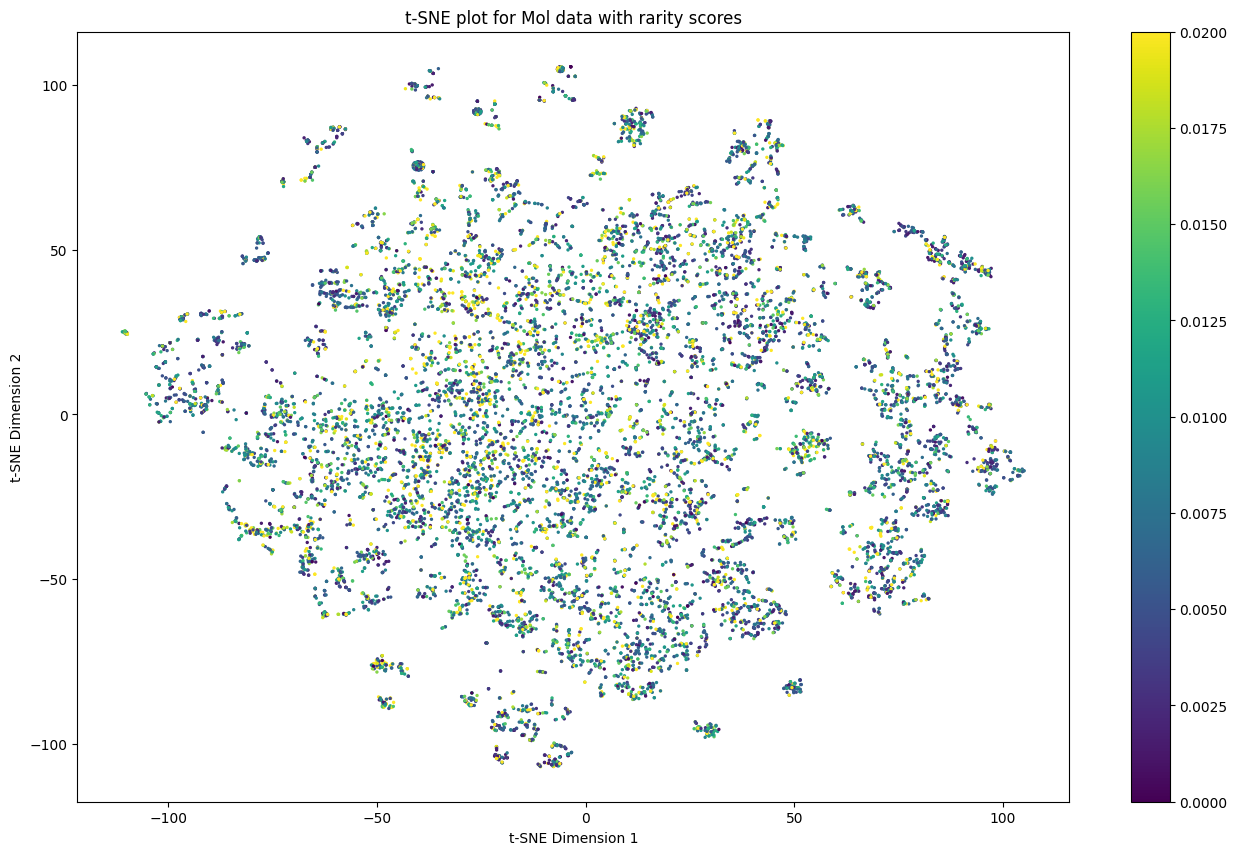

In [218]:
# Erstelle den Plot
plt.figure(figsize=(16,10))
sc = plt.scatter(tsne_df['tsne_2d_one'], tsne_df['tsne_2d_two'], s=2, c=rarity_score_lof, cmap='viridis', vmax=0.02)
plt.colorbar(sc)
plt.title('t-SNE plot for Mol data with rarity scores')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## SOS

In [219]:
from pyod.models.sos import SOS

# SOS-Modell mit Standardparametern instanziieren
sos = SOS(metric='euclidean', perplexity=200)

# SOS an der Ähnlichkeitsmatrix anpassen
sos.fit(distances)

# Anomalie-Scores berechnen
outlier_scores_sos = sos.decision_function(distances)

# Normalisierung der Scores
min_score = min(outlier_scores_sos)
max_score = max(outlier_scores_sos)
rarity_score_sos = (outlier_scores_sos - min_score) / (max_score - min_score)


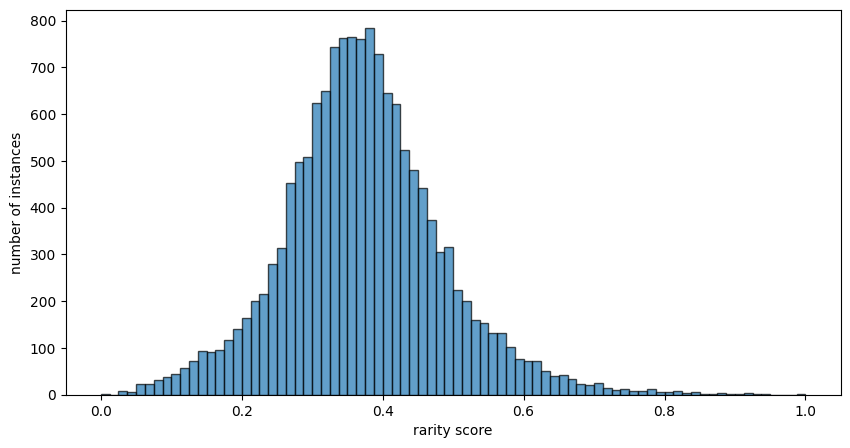

In [220]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_sos, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('rarity score')
plt.ylabel('number of instances')
plt.show()

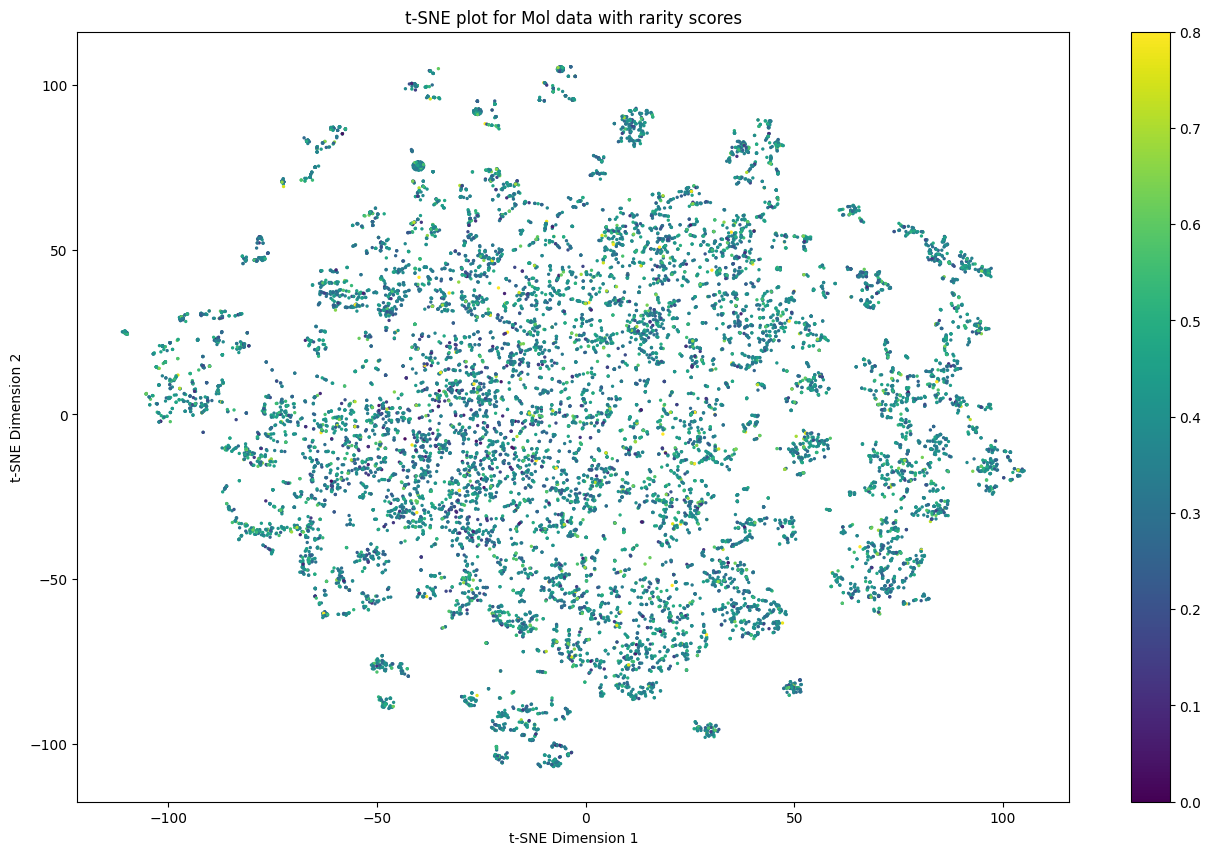

In [223]:
# Erstelle den Plot
plt.figure(figsize=(16,10))
sc = plt.scatter(tsne_df['tsne_2d_one'], tsne_df['tsne_2d_two'], s=2, c=rarity_score_sos, cmap='viridis', vmax=0.8)
plt.colorbar(sc)
plt.title('t-SNE plot for Mol data with rarity scores')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()